## 1.CrossEntropyLoss

Epoch [1/10], Loss: 0.2953, Accuracy: 90.77%
Epoch [2/10], Loss: 0.0934, Accuracy: 97.15%
Epoch [3/10], Loss: 0.0640, Accuracy: 98.01%
Epoch [4/10], Loss: 0.0480, Accuracy: 98.52%
Epoch [5/10], Loss: 0.0396, Accuracy: 98.76%
Epoch [6/10], Loss: 0.0298, Accuracy: 99.04%
Epoch [7/10], Loss: 0.0239, Accuracy: 99.22%
Epoch [8/10], Loss: 0.0231, Accuracy: 99.25%
Epoch [9/10], Loss: 0.0209, Accuracy: 99.29%
Epoch [10/10], Loss: 0.0189, Accuracy: 99.36%
Test Loss: 0.2518, Test Accuracy: 94.98%
Test Loss: 0.2608, Test Accuracy: 94.97%
Test Loss: 0.2544, Test Accuracy: 95.12%
Test Loss: 0.2567, Test Accuracy: 95.27%
Test Loss: 0.2522, Test Accuracy: 95.12%
Test Loss: 0.2611, Test Accuracy: 94.98%
Test Loss: 0.2573, Test Accuracy: 95.06%
Test Loss: 0.2526, Test Accuracy: 95.14%
Test Loss: 0.2559, Test Accuracy: 95.11%
Test Loss: 0.2595, Test Accuracy: 95.05%


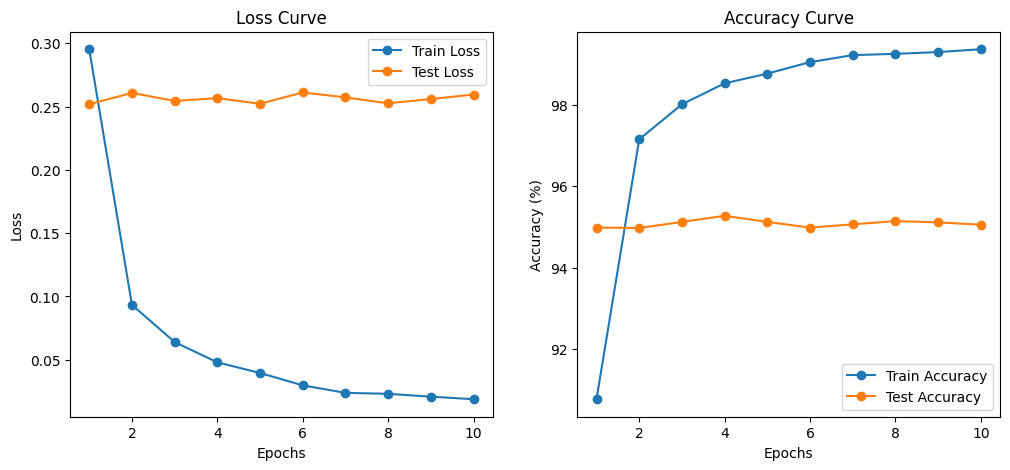

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Download and load the KMNIST dataset
# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Design a Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Input channels: 1, Output channels: 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Input channels: 32, Output channels: 64

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling

        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input size: 64 * 7 * 7, Output size: 128
        self.fc2 = nn.Linear(128, 10)          # Output size: number of classes (10)

    def forward(self, x):
        # Forward propagation
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)  # Flatten feature maps into a 1D vector

        # Fully connected layers
        x = F.relu(self.fc1(x))     # Fully connected -> ReLU
        x = self.fc2(x)             # Output layer (without Softmax)

        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# 3. Train and test the model
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backward propagation
            optimizer.step()       # Update parameters

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_losses = []
    test_accuracies = []

    with torch.no_grad():  # No need to compute gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

    return avg_test_loss, avg_test_acc

# 4. Performance visualization
def plot_performance(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and testing losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, test_losses, label="Test Loss", marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# 5. Run training and testing
# Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Test the model
test_losses = []
test_accuracies = []
for _ in range(10):  # Test multiple times and take the average
    test_loss, test_acc = test_model(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Visualize performance
plot_performance(train_losses, train_accuracies, test_losses, test_accuracies)

## 2.Add L2 regularization

Epoch [1/10], Loss: 0.4420, Accuracy: 86.21%
Epoch [2/10], Loss: 0.1925, Accuracy: 94.16%
Epoch [3/10], Loss: 0.1500, Accuracy: 95.31%
Epoch [4/10], Loss: 0.1220, Accuracy: 96.24%
Epoch [5/10], Loss: 0.1096, Accuracy: 96.65%
Epoch [6/10], Loss: 0.0964, Accuracy: 96.95%
Epoch [7/10], Loss: 0.0876, Accuracy: 97.23%
Epoch [8/10], Loss: 0.0810, Accuracy: 97.50%
Epoch [9/10], Loss: 0.0745, Accuracy: 97.63%
Epoch [10/10], Loss: 0.0711, Accuracy: 97.70%
Test Loss: 0.1859, Test Accuracy: 95.54%
Test Loss: 0.1914, Test Accuracy: 95.21%
Test Loss: 0.1863, Test Accuracy: 95.26%
Test Loss: 0.1837, Test Accuracy: 95.50%
Test Loss: 0.1847, Test Accuracy: 95.37%
Test Loss: 0.1875, Test Accuracy: 95.32%
Test Loss: 0.1826, Test Accuracy: 95.38%
Test Loss: 0.1866, Test Accuracy: 95.46%
Test Loss: 0.1849, Test Accuracy: 95.40%
Test Loss: 0.1895, Test Accuracy: 95.25%


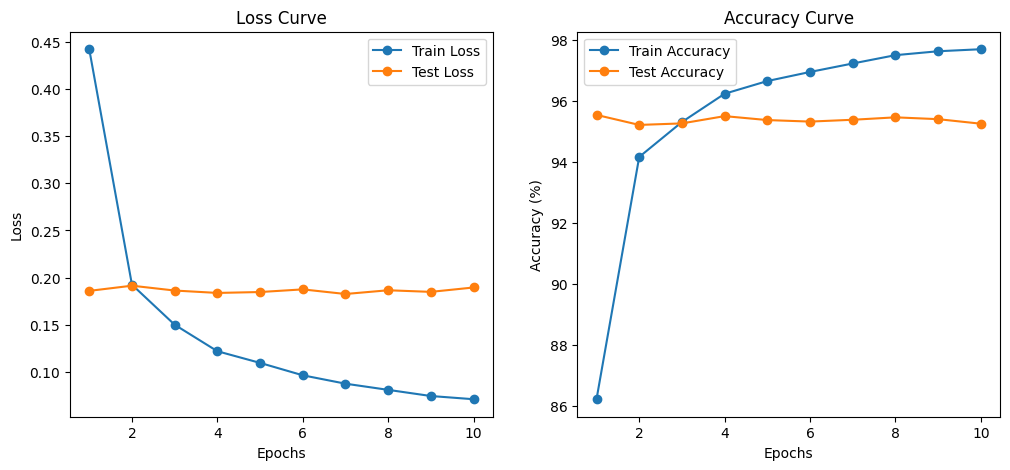

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Download and load the KMNIST dataset
# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees # 数据增强技术，增加模型泛化能力
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]            # 将像素值从 [0, 1] 范围归一化到 [-1, 1]。
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Design a Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define convolutional layers # 提取图像的空间特征
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Input channels: 1, Output channels: 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Input channels: 32, Output channels: 64

        # Define pooling layer     # 通过最大池化减少特征图的尺寸
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling

        # Add Dropout for regularization
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        # Define fully connected layers 将提取的特征映射到分类输出
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input size: 64 * 7 * 7, Output size: 128
        self.fc2 = nn.Linear(128, 10)          # Output size: number of classes (10)

    def forward(self, x):
        # Forward propagation
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)  # Flatten feature maps into a 1D vector

        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))     # Fully connected -> ReLU
        x = self.dropout(x)         # Apply Dropout
        x = self.fc2(x)             # Output layer (without Softmax)

        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss function      # 损失函数（交叉熵损失）
#optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer   # 优化器（Adam）

# Add L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization with weight decay

# 3. Train and test the model
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()     # Clear gradients
            loss.backward()        # Backward propagation
            optimizer.step()       # Update parameters

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_losses = []
    test_accuracies = []

    with torch.no_grad():  # No need to compute gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

    return avg_test_loss, avg_test_acc

# 4. Performance visualization
def plot_performance(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and testing losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, test_losses, label="Test Loss", marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# 5. Run training and testing
# Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Test the model
test_losses = []
test_accuracies = []
for _ in range(10):  # Test multiple times and take the average
    test_loss, test_acc = test_model(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Visualize performance
plot_performance(train_losses, train_accuracies, test_losses, test_accuracies)

## 3. Label smoothing cross entropy loss

100%|██████████| 18.2M/18.2M [00:12<00:00, 1.45MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 333kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.30MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.97MB/s]


Epoch [1/10], Loss: 0.9276, Accuracy: 86.52%
Epoch [2/10], Loss: 0.7497, Accuracy: 94.59%
Epoch [3/10], Loss: 0.7121, Accuracy: 95.94%
Epoch [4/10], Loss: 0.6882, Accuracy: 96.62%
Epoch [5/10], Loss: 0.6737, Accuracy: 97.14%
Epoch [6/10], Loss: 0.6611, Accuracy: 97.40%
Epoch [7/10], Loss: 0.6528, Accuracy: 97.66%
Epoch [8/10], Loss: 0.6470, Accuracy: 97.83%
Epoch [9/10], Loss: 0.6435, Accuracy: 97.89%
Epoch [10/10], Loss: 0.6385, Accuracy: 98.06%
Test Loss: 0.6725, Test Accuracy: 94.86%
Test Loss: 0.6722, Test Accuracy: 94.87%
Test Loss: 0.6712, Test Accuracy: 94.88%
Test Loss: 0.6716, Test Accuracy: 94.89%
Test Loss: 0.6719, Test Accuracy: 94.94%
Test Loss: 0.6707, Test Accuracy: 94.80%
Test Loss: 0.6721, Test Accuracy: 94.57%
Test Loss: 0.6724, Test Accuracy: 94.79%
Test Loss: 0.6712, Test Accuracy: 95.04%
Test Loss: 0.6695, Test Accuracy: 95.12%


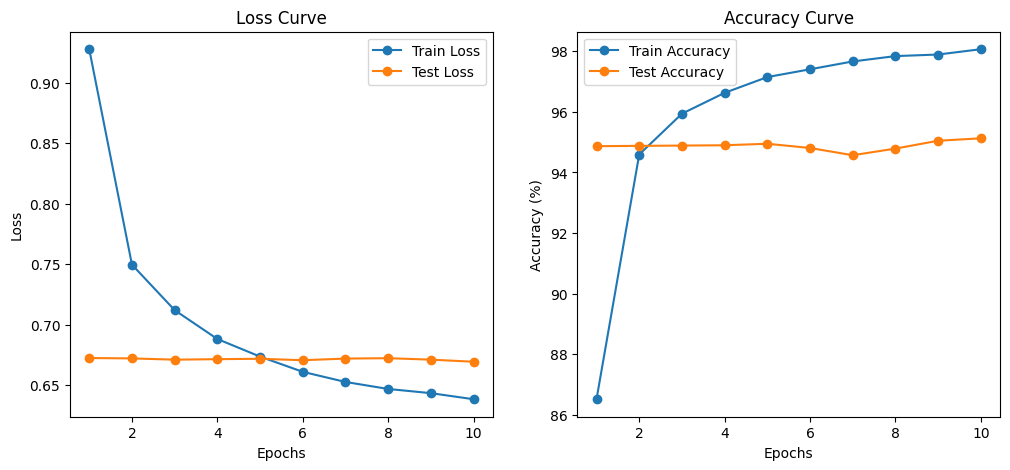

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Download and load the KMNIST dataset
# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees # 数据增强技术，增加模型泛化能力
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]            # 将像素值从 [0, 1] 范围归一化到 [-1, 1]。
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Design a Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define convolutional layers # 提取图像的空间特征
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Input channels: 1, Output channels: 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Input channels: 32, Output channels: 64

        # Define pooling layer     # 通过最大池化减少特征图的尺寸
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling

        # Add Dropout for regularization
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        # Define fully connected layers 将提取的特征映射到分类输出
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input size: 64 * 7 * 7, Output size: 128
        self.fc2 = nn.Linear(128, 10)          # Output size: number of classes (10)

    def forward(self, x):
        # Forward propagation
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)  # Flatten feature maps into a 1D vector

        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))     # Fully connected -> ReLU
        x = self.dropout(x)         # Apply Dropout
        x = self.fc2(x)             # Output layer (without Softmax)

        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)

# 3. Define Label Smoothing Cross-Entropy Loss 标签平滑交叉熵损失
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, inputs, targets):
        n_classes = inputs.size()[-1]
        log_preds = F.log_softmax(inputs, dim=-1)
        loss = -log_preds.sum(dim=-1)
        nll_loss = F.nll_loss(log_preds, targets, reduction='none')
        smooth_loss = loss / n_classes
        final_loss = (1 - self.epsilon) * nll_loss + self.epsilon * smooth_loss

        if self.reduction == 'mean':
            return final_loss.mean()
        elif self.reduction == 'sum':
            return final_loss.sum()
        else:
            return final_loss

# Replace CrossEntropyLoss with LabelSmoothingCrossEntropy
criterion = LabelSmoothingCrossEntropy(epsilon=0.1).to(device)

# Add L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization with weight decay

# 3. Train and test the model
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backward propagation
            optimizer.step()       # Update parameters

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_losses = []
    test_accuracies = []

    with torch.no_grad():  # No need to compute gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

    return avg_test_loss, avg_test_acc

# 4. Performance visualization
def plot_performance(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and testing losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, test_losses, label="Test Loss", marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# 5. Run training and testing
# Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Test the model
test_losses = []
test_accuracies = []
for _ in range(10):  # Test multiple times and take the average
    test_loss, test_acc = test_model(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Visualize performance
plot_performance(train_losses, train_accuracies, test_losses, test_accuracies)

## 4.Softmax + KL Divergence Loss

Epoch [1/10], Loss: 0.4569, Accuracy: 85.65%
Epoch [2/10], Loss: 0.2093, Accuracy: 93.59%
Epoch [3/10], Loss: 0.1633, Accuracy: 95.00%
Epoch [4/10], Loss: 0.1349, Accuracy: 95.78%
Epoch [5/10], Loss: 0.1154, Accuracy: 96.50%
Epoch [6/10], Loss: 0.1082, Accuracy: 96.65%
Epoch [7/10], Loss: 0.0905, Accuracy: 97.20%
Epoch [8/10], Loss: 0.0861, Accuracy: 97.26%
Epoch [9/10], Loss: 0.0813, Accuracy: 97.41%
Epoch [10/10], Loss: 0.0762, Accuracy: 97.58%
Test Loss: 0.1774, Test Accuracy: 95.17%
Test Loss: 0.1830, Test Accuracy: 94.95%
Test Loss: 0.1886, Test Accuracy: 94.84%
Test Loss: 0.1877, Test Accuracy: 95.06%
Test Loss: 0.1847, Test Accuracy: 95.05%
Test Loss: 0.1864, Test Accuracy: 95.06%
Test Loss: 0.1785, Test Accuracy: 95.21%
Test Loss: 0.1783, Test Accuracy: 95.27%
Test Loss: 0.1877, Test Accuracy: 94.85%
Test Loss: 0.1869, Test Accuracy: 94.98%


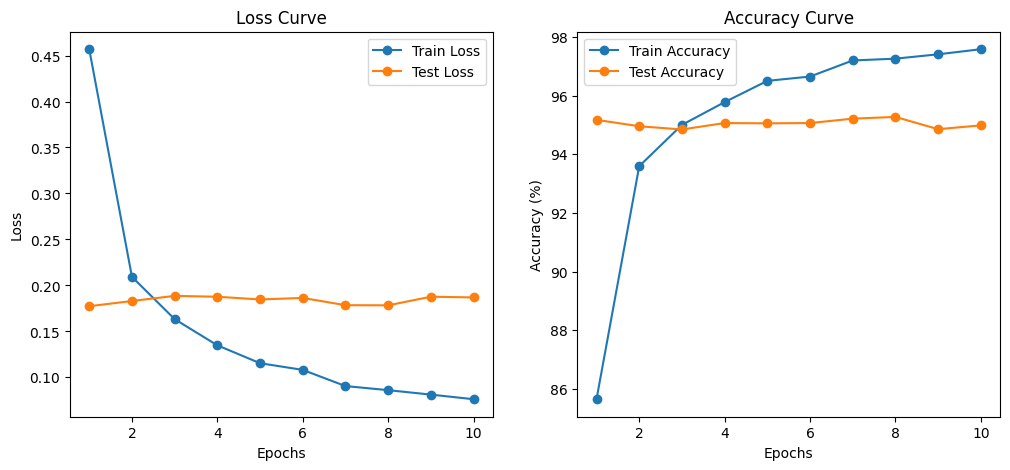

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import csv

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output size: number of classes (10)

    def forward(self, x):
        # Forward propagation
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)  # Flatten feature maps into a 1D vector

        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))     # Fully connected -> ReLU
        x = self.dropout(x)         # Apply Dropout
        x = self.fc2(x)             # Output layer (logits)

        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)

# Use KLDivLoss instead of CrossEntropyLoss
criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence Loss

# Optimizer with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    train_losses = []
    train_accuracies = []

    # Open CSV file for saving training data
    with open('training_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'train_loss', 'train_accuracy'])  # Write header

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU

                # Forward pass
                outputs = model(images)  # Logits

                # Convert logits to log-probabilities
                log_probs = F.log_softmax(outputs, dim=1)

                # Convert labels to one-hot encoding
                target_probs = F.one_hot(labels, num_classes=10).float()

                # Compute KL Divergence Loss
                loss = criterion(log_probs, target_probs)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate average loss and accuracy
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # Write training data to CSV
            writer.writerow([epoch+1, epoch_loss, epoch_acc])

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_losses = []
    test_accuracies = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # Forward pass
            outputs = model(images)  # Logits

            # Convert logits to log-probabilities
            log_probs = F.log_softmax(outputs, dim=1)

            # Convert labels to one-hot encoding
            target_probs = F.one_hot(labels, num_classes=10).float()

            # Compute KL Divergence Loss
            loss = criterion(log_probs, target_probs)

            # Track loss and accuracy
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

    return avg_test_loss, avg_test_acc

# Performance visualization
def plot_performance(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and testing losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, test_losses, label="Test Loss", marker='o')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# Save test data to CSV
def save_test_data_to_csv(test_losses, test_accuracies):
    with open('test_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'test_loss', 'test_accuracy'])  # Write header
        for epoch, (loss, acc) in enumerate(zip(test_losses, test_accuracies), start=1):
            writer.writerow([epoch, loss, acc])

# Run training and testing
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

test_losses = []
test_accuracies = []
for _ in range(10):  # Test multiple times and take the average
    test_loss, test_acc = test_model(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Save test data to CSV
save_test_data_to_csv(test_losses, test_accuracies)

# Visualize performance
plot_performance(train_losses, train_accuracies, test_losses, test_accuracies)